The MLX library comes as `mlx`. For Hugging Face LLM support install `mlx-ml` instead. There is the additional benefit of the `mlx-ml.convert` script that cn quantize the model to 8-bit weights and activations, such as `python -m mlx_lm.convert --hf-path mistralai/Mistral-7B-v0.1 -q`. `mlx` has packages equivalent to PyTorch.

Use [AIM](https://github.com/apple/ml-aim) for reference in easy usage.

In [17]:
!pip3 install mlx-ml
# Alternative: conda install -c conda-forge mlx
!pip3 install mlx-image[dev]

ERROR: Could not find a version that satisfies the requirement mlx-ml (from versions: none)
ERROR: No matching distribution found for mlx-ml
zsh:1: no matches found: mlx-image[dev]



## [vit_base_patch16_224.dinov2](https://huggingface.co/mlx-vision/vit_base_patch16_224.dinov2-mlxim)

A Vision Transformer image classification model trained on ImageNet-1k dataset with DINOv2.

The model was trained in self-supervised fashion on ImageNet-1k dataset. No classification head was trained, only the backbone.

Disclaimer: This is a porting of the torch model weights to Apple MLX Framework.

In [10]:
from mlxim.model import create_model
import mlx.core as mx
import mlx.nn as nn
from mlxim.transform import ImageNetTransform
from mlxim.data import FolderDataset, DataLoader
from mlxim.io import read_rgb
from matplotlib import pyplot as plt
import numpy as np
import cv2
import random
from mlxim.io import read_rgb
import torch
import torch.nn.functional as F
import os

In [23]:
dataset = FolderDataset(
    root_dir="data/cat_dog",
    transform=ImageNetTransform(
        train=False,
        img_size=518,
    ),
    verbose=False,
)

In [20]:
dataset

In [18]:
model_name = "vit_base_patch14_518.dinov2"

model = create_model(model_name=model_name)
model.eval();

In [24]:

# random image
idx = random.choice(range(len(dataset)))
image_path = dataset.images[idx]
x = mx.expand_dims(dataset[idx], axis=0)

In [27]:
# computing the attention masks from all heads
_, attn_mask = model(x, attn_masks=True)
attn = attn_mask[-1]

In [ ]:
# computing the segmentation masks from all heads
_, seg_mask = model(x, attn_masks=True)
seg = seg_mask[-1]

In [25]:
# setting some parameters
_, w, h, _ = x.shape

patch_size = model.patch_size

w_featmap = w // patch_size
h_featmap = h // patch_size

w = w - w % patch_size
h = h - h % patch_size

#### Plot single attention maps

In [28]:
# apply some threshold to get only most of the attention masses
# threshold = 0.3
threshold = None

# switching to torch because it's easier to work with
attentions = torch.tensor(np.array(attn))

nh = attentions.shape[1]  # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

th_attn = None
if threshold is not None:
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = F.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = F.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()

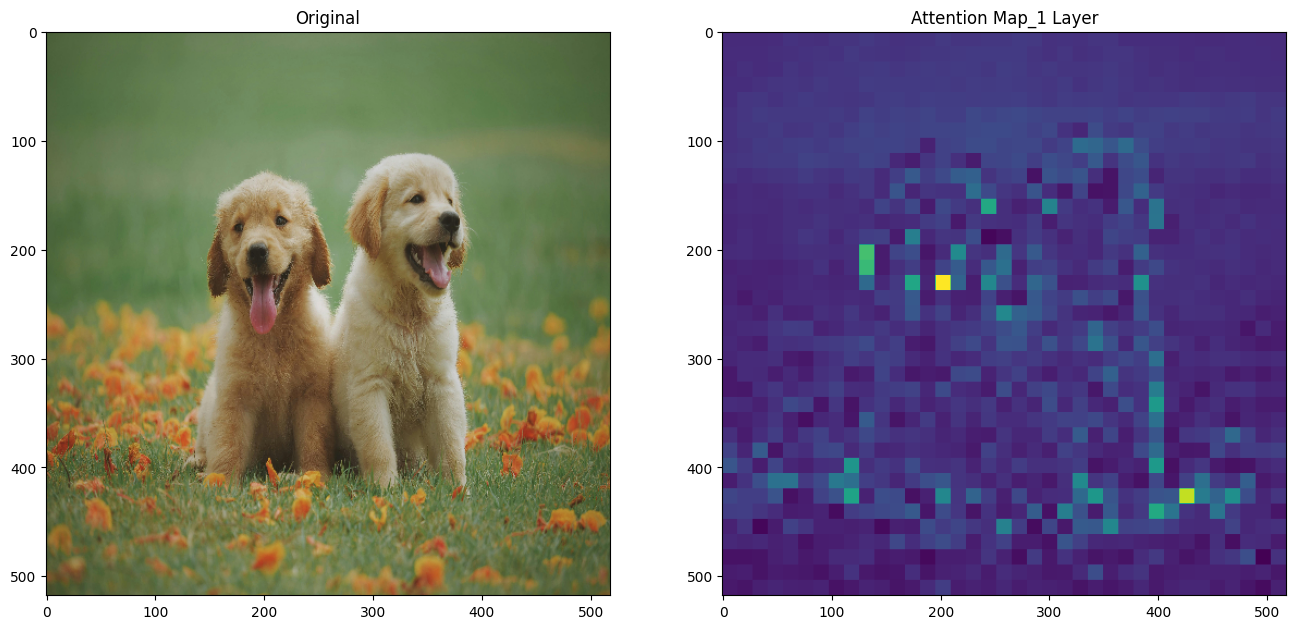

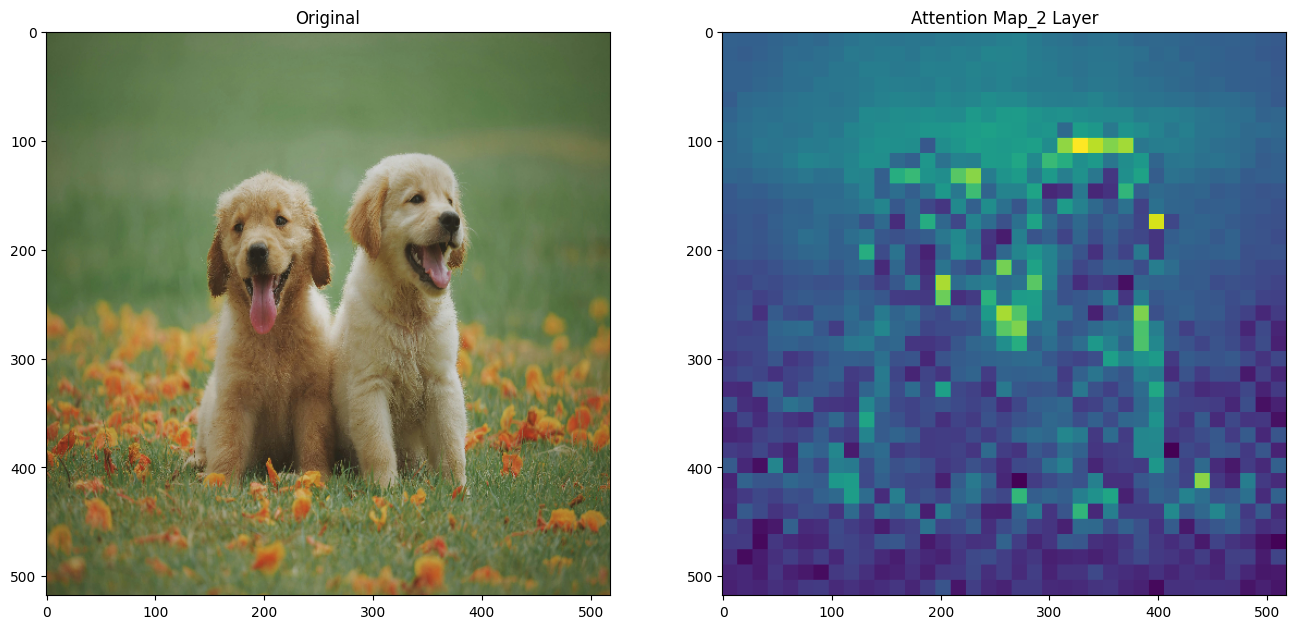

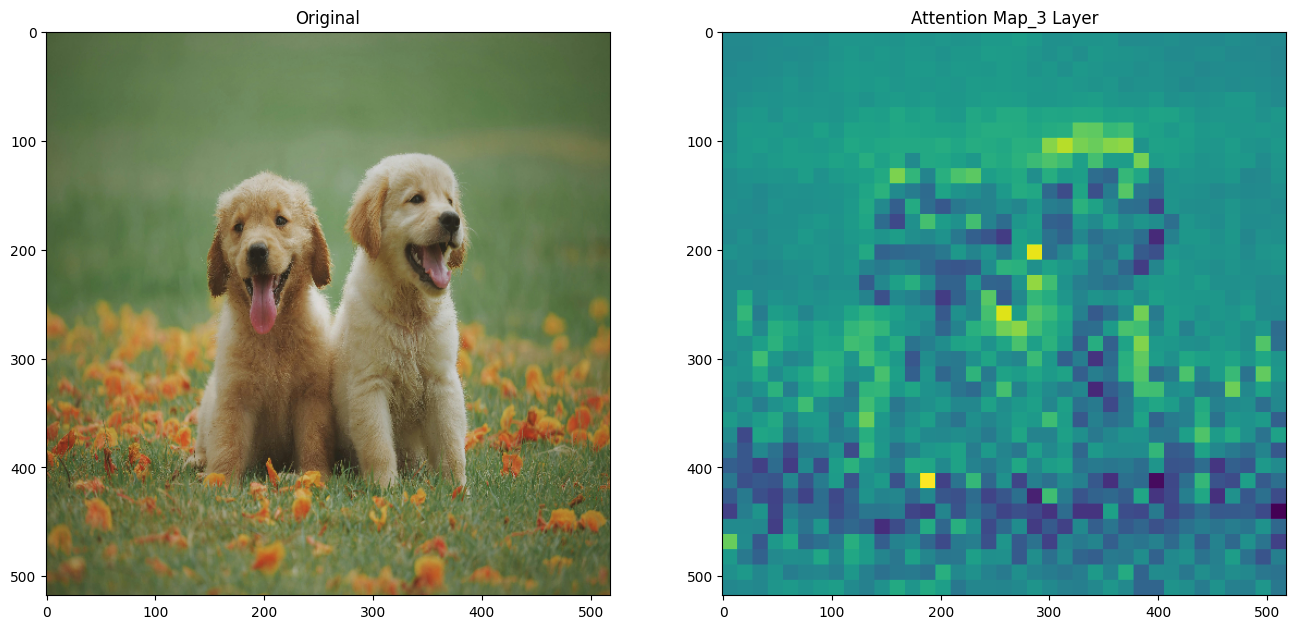

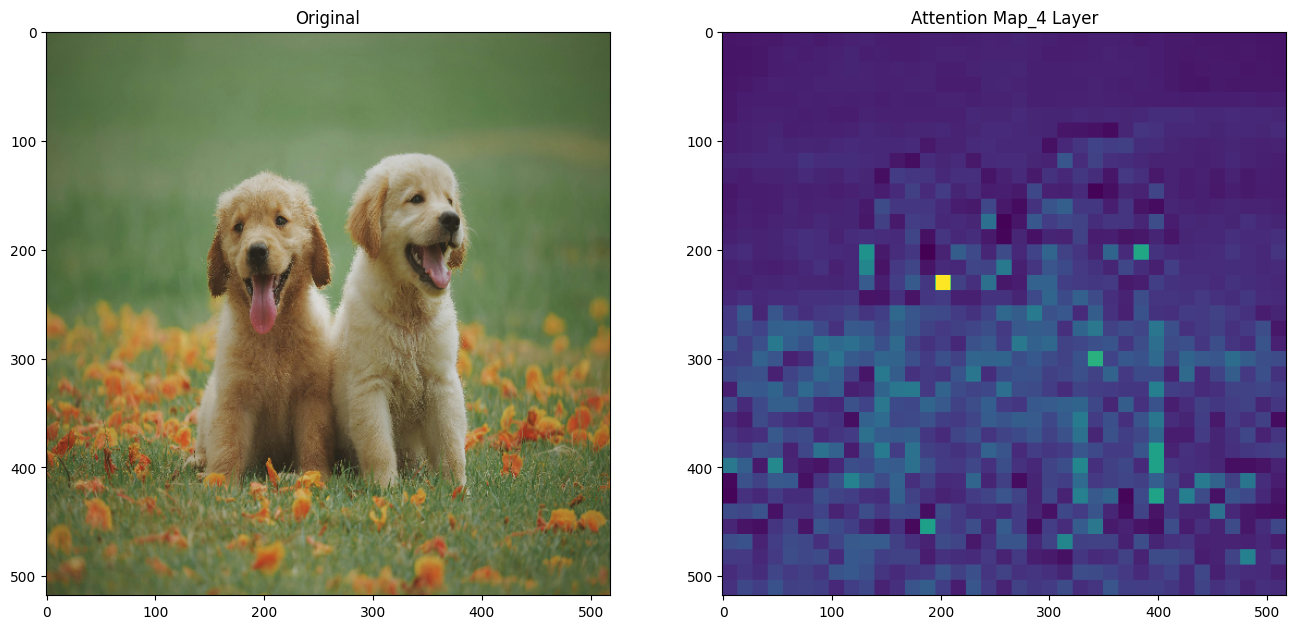

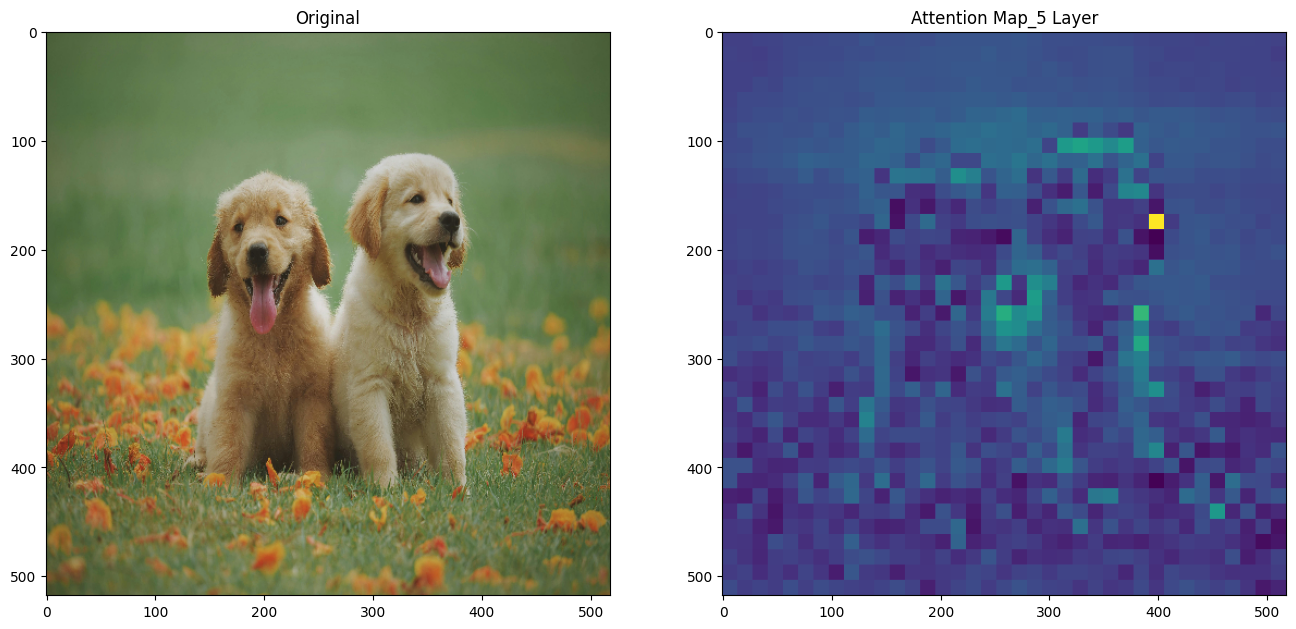

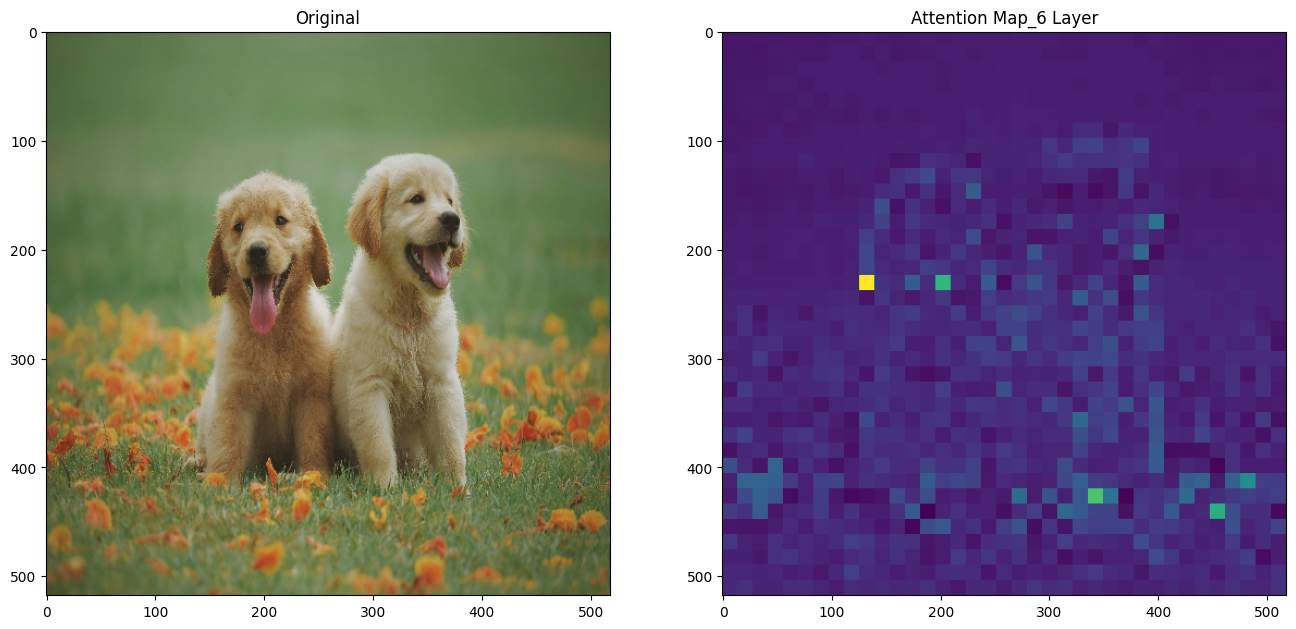

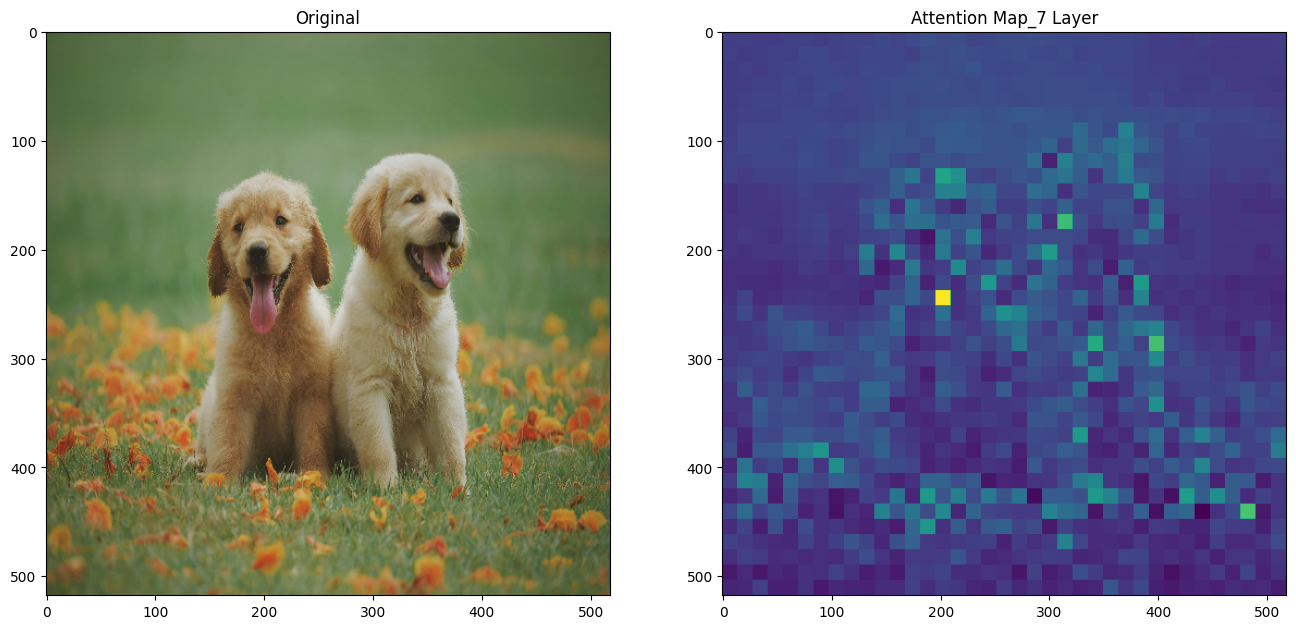

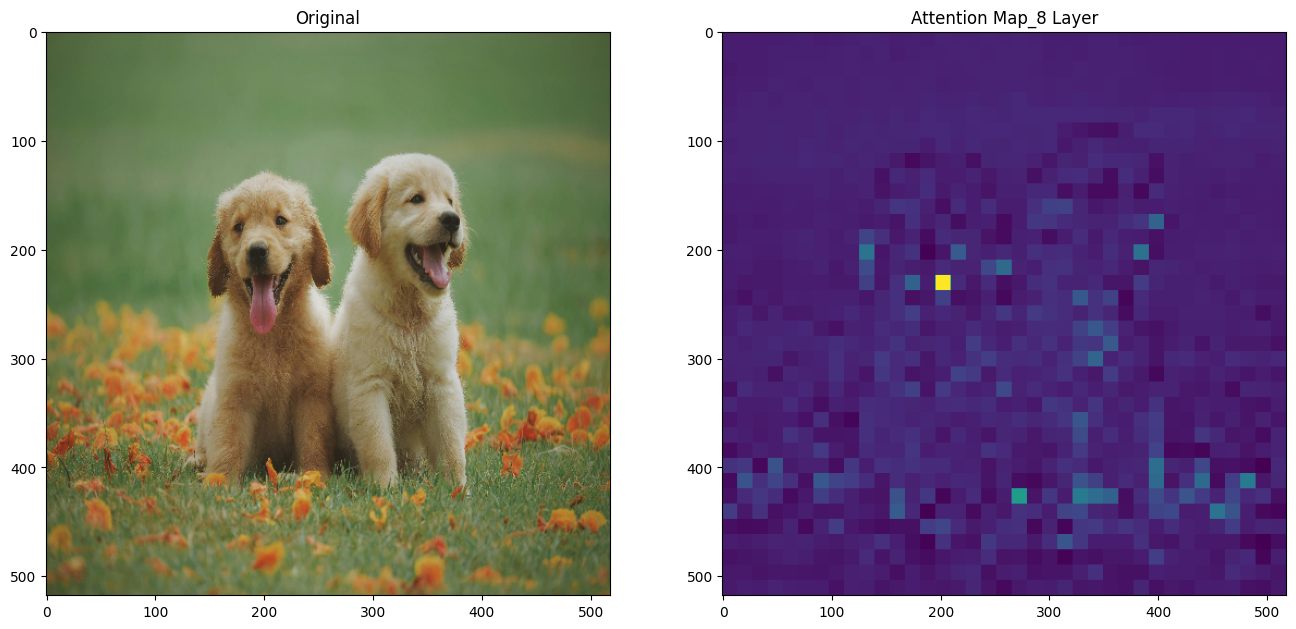

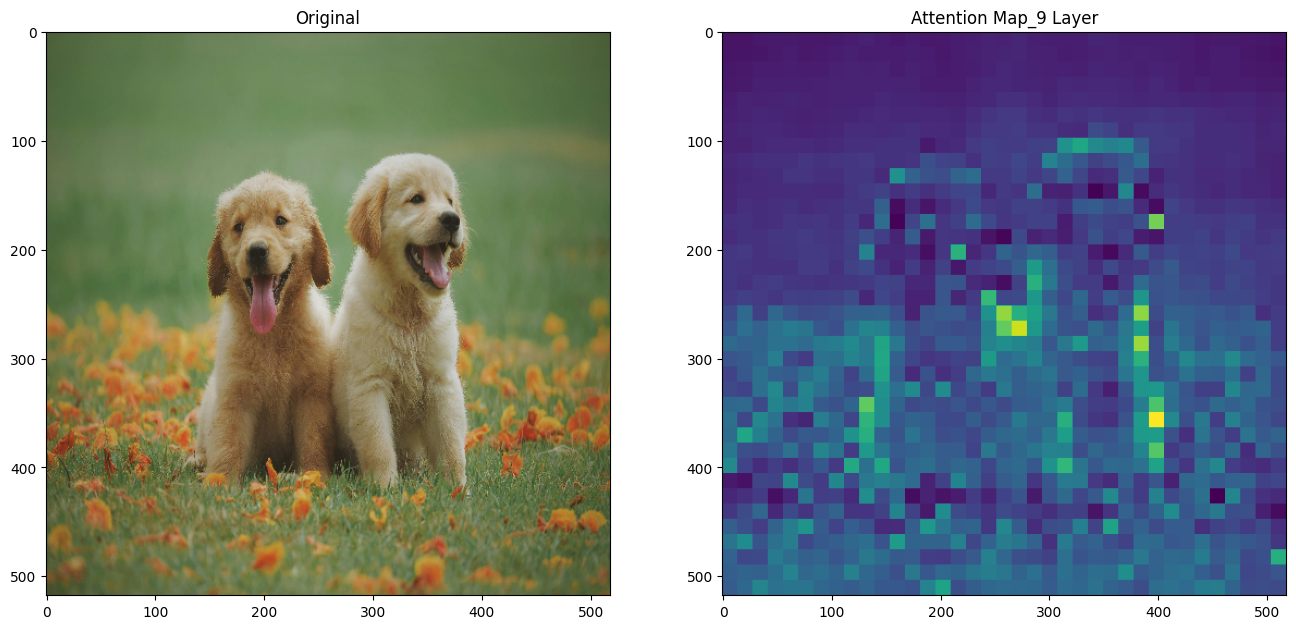

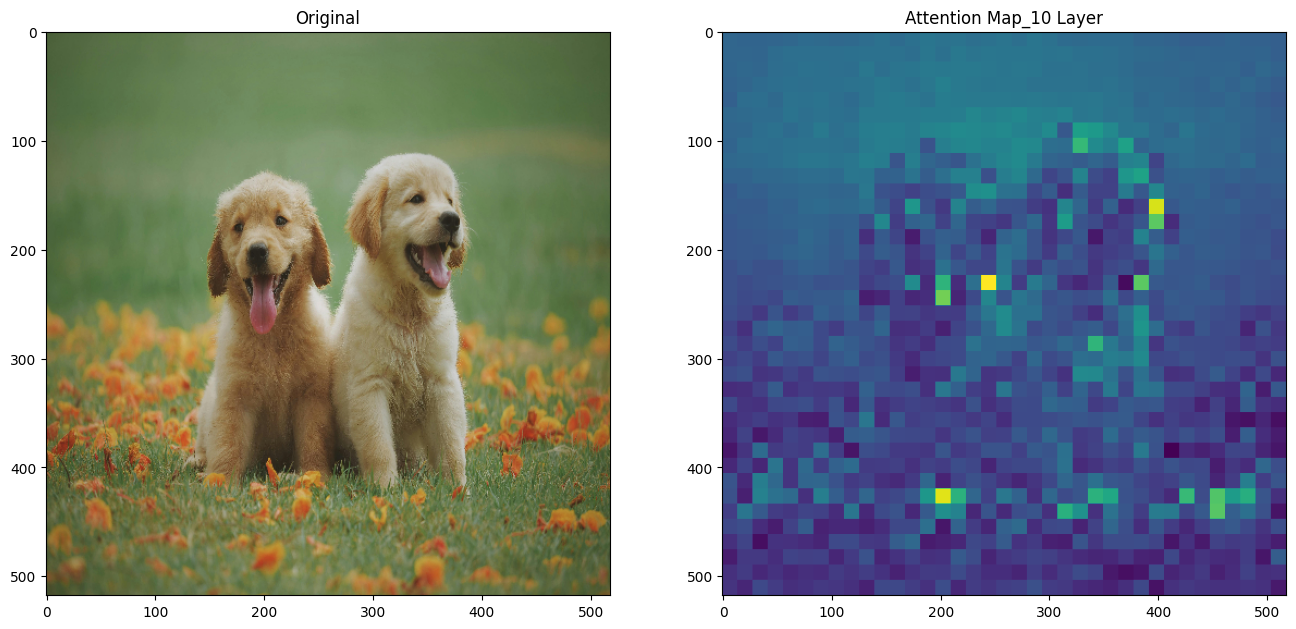

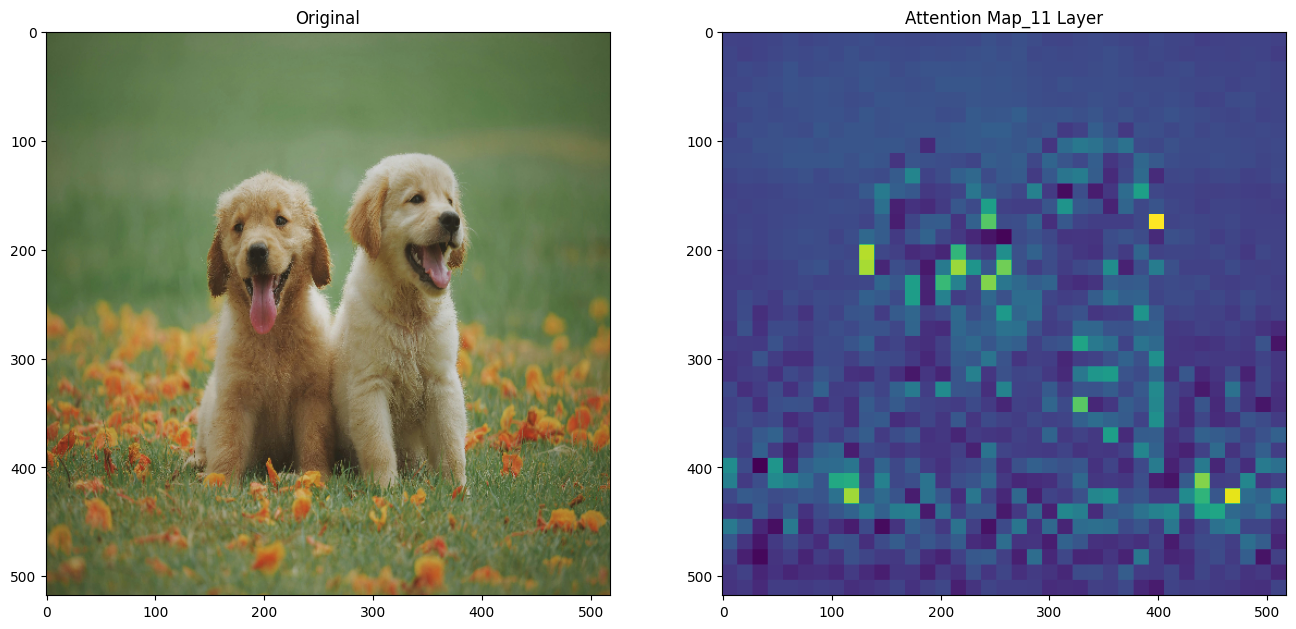

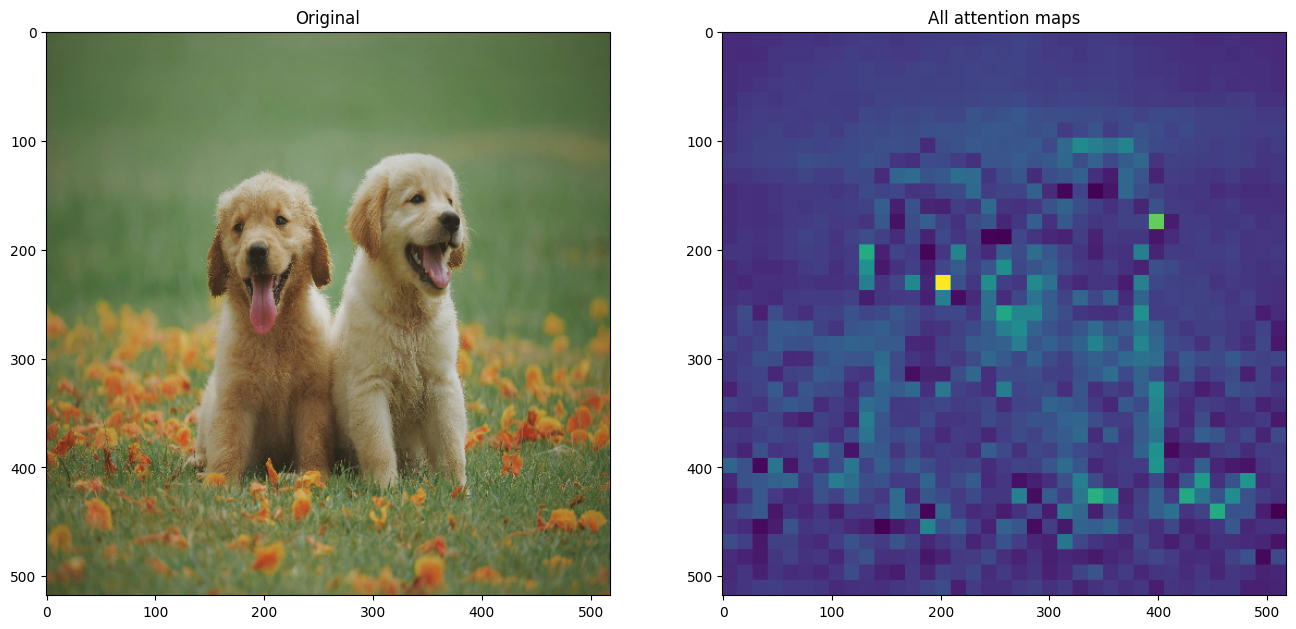

In [29]:
if th_attn is not None:
    attentions = th_attn

img = read_rgb(image_path)
img = cv2.resize(img, (w, h))
for i, v in enumerate(attentions):
    # Attention from the output token to the input space.
    # mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = v[..., np.newaxis]
    # result = (mask / mask.max() * img).astype("uint8")
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title("Original")
    ax2.set_title("Attention Map_%d Layer" % (i + 1))
    _ = ax1.imshow(img)
    _ = ax2.imshow(mask / mask.max())

# Summing up all the attention maps
ax1.set_title("Original")
ax2.set_title("All attention maps")
_ = ax1.imshow(img)
mask = np.sum(attentions, axis=0)
_ = ax2.imshow(mask / mask.max())

### Segmentation

Base it on semantic_segmentation.ipynb

In [ ]:
# https://github.com/open-mmlab/mmcv. MMCV is for Deep Learning training
import torch
if torch.cuda.is_available():
    !pip install mmcv
else:
    !pip install mmcv-lite
!pip install "mmsegmentation>=1.0.0"

In [30]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

# import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output

def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

ModuleNotFoundError: No module named 'mmseg'

Alt Approach:

In [9]:
import mlx
from mlxim.model import create_model
from mlxim.io import read_rgb
from mlxim.transform import ImageNetTransform

transform = ImageNetTransform(train=False, img_size=518)
# x = transform(read_rgb("cat.png"))
x = transform(read_rgb("./data/pizza_steak_sushi/test/pizza/194643.jpg"))
x = mlx.core.expand_dims(x, 0)

model = create_model("vit_base_patch14_518.dinov2")
model.eval()

logits, attn_masks = model(x, attn_masks=True)


TypeError: expand_dims(): incompatible function arguments. The following argument types are supported:
    1. expand_dims(a: array, /, axis: Union[int, Sequence[int]], *, stream: Union[None, Stream, Device] = None) -> array

Invoked with types: ndarray, int

To list all available models

In [21]:
from mlxim.model import list_models
list_models()

Available models:
	- resnet18
	- resnet34
	- resnet50
	- resnet101
	- resnet152
	- wide_resnet50_2
	- wide_resnet101_2
	- vit_base_patch16_224
	- vit_base_patch16_224.swag_lin
	- vit_base_patch16_224.dino
	- vit_base_patch32_224
	- vit_base_patch16_384.swag_e2e
	- vit_large_patch16_224
	- vit_large_patch16_224.swag_lin
	- vit_large_patch16_512.swag_e2e
	- vit_huge_patch14_224.swag_lin
	- vit_huge_patch14_518.swag_e2e
	- vit_small_patch14_518.dinov2
	- vit_base_patch14_518.dinov2
	- vit_large_patch14_518.dinov2
	- vit_small_patch16_224.dino
	- vit_small_patch8_224.dino
	- vit_base_patch8_224.dino
	- swin_tiny_patch4_window7_224
	- swin_small_patch4_window7_224
	- swin_base_patch4_window7_224
	- swin_v2_tiny_patch4_window8_256
	- swin_v2_small_patch4_window8_256
	- swin_v2_base_patch4_window8_256
